## Experimenting with Rewards
    In this notebook, we will experiment with different ways of rewarding the agent and comparing them.

In [1]:
import numpy as np
import gym
import random
import time
from IPython.display import clear_output
from matplotlib import pyplot as plot
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class State:
    def __init__(self, x, y):
        self.x = x
        self.y = y

up = lambda state: State(state.x, state.y-1)
down = lambda state: State(state.x, state.y+1)
left = lambda state: State(state.x - 1, state.y)
right = lambda state: State(state.x + 1, state.y)
action_space_size = 4
state_space_size = 63
action_space = [up, down, left, right]

def get_sample():
    random_pos = np.random.randint(0,4)
    return action_space[random_pos], random_pos

def get_num_state(state):
    return state.y*9 + state.x

def reset():
    initial_state = State(1,1)
    return initial_state,get_num_state(initial_state)

def is_goal_state(state):
    return state.x == 7 and state.y == 4

def move(state, action):
    wind_val = {3:0.1, 4:0.2, 5:0.15}
    new_state = action(state)
    wind_treshold = np.random.random()
    wind_prob = wind_val.get(new_state.x)
    if wind_prob:
        if wind_treshold < wind_prob:
            new_state.y -= 1
    reward = get_reward(new_state)
    done = is_goal_state(new_state) or reward == -10
    if reward == -10:
        new_state = None
    return new_state, reward, done

def rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate):
    # This cycle is to calculate the average reward/episodes and its only purpose is to plot the nice graph below that
# shows how the agent learns to maximize the reward.
    rewards_avg = []
    q_table_avg = []
    num_times_goal_reached_avg = []
    for it in range(100):
        #print('average ', it)
        rewards_all_episodes=[]
        q_table_all_episodes = []
        num_times_goal_reached = 0
        # exporation-exploitation trade-off params
        exploration_rate = 1

        # init q table in zeros
        q_table = np.zeros((state_space_size, action_space_size))

        # iterate over the episodes
        for episode in range(num_episodes):
            state, num_state = reset()
            done = False
            rewards_current_episode = 0

            # iterate over the steps for an episode
            for step in range(max_steps_per_episode):
                # Exploration-exploitation trade-off
                exploration_rate_threshold = np.random.random()
                if exploration_rate_threshold <= exploration_rate:
                    action, pos_action = get_sample()
                else:
                    q_row = q_table[num_state]
                    pos_action = np.where(q_row == max(q_row))[0][0]
                    action = action_space[pos_action]
                # Take action
                new_state, reward, done = move(state, action)
                if new_state == None:
                    num_new_state = get_num_state(state)
                else:
                    num_new_state = get_num_state(new_state)
                # Update Q-table for Q(s,a)
                max_value = max(q_table[num_new_state])
                future_q=learning_rate*(reward + discount_rate*max_value)
                q_table[num_state, pos_action] = (1-learning_rate)*q_table[num_state,pos_action] + future_q

                # transition next state
                state = new_state
                num_state = num_new_state
                rewards_current_episode += reward
                        
                if done == True: 
                    break

            # Exploration rate decay
            exploration_rate = min_exploration_rate + (max_exploration_rate-min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
            
            if state!=None and is_goal_state(state):
                num_times_goal_reached += 1
                
            rewards_all_episodes.append(rewards_current_episode)
            q_table_all_episodes.append(q_table)
            
        num_times_goal_reached_avg.append(num_times_goal_reached)        
        rewards_avg.append(rewards_all_episodes)
        q_table_avg.append(q_table_all_episodes)
    return rewards_avg, q_table, num_times_goal_reached_avg
        
def plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath):
    x = [i for i in range(0,num_episodes)]
    y = np.mean(rewards_avg, axis=0)
    plot.xlabel('Episodes')
    plot.ylabel('Reward')
    plot.plot(x, y,'o')
    plot.title("Episodes_vs_Rewards")
    plt.savefig(filepath)
    plt.show()
    
def get_state_actions(q_table):
    q_table_best_actions =[]
    for i in range(q_table.shape[0]):
        max_pos = np.argmax(q_table[i])
        q_table_best_actions.append(max_pos)
    return q_table_best_actions
    
def plot_optimal_policy(q_table, filepath):
    w = 0.3
    i,j=0,0
    best_actions_matrix = np.array(get_state_actions(q_table)).reshape(7,9)
    arrow_dict = {0:lambda i,j:plt.arrow(x=i, y=j-0.25, dx=0, dy=w, width=.05)  ,1:lambda i,j:plt.arrow(x=i, y=j+0.25, dx=0, dy=-w, width=.05),2:lambda i,j:plt.arrow(x=i+0.2, y=j, dx=-w, dy=0, width=.05),3:lambda i,j:plt.arrow(x=i-0.2, y=j, dx=w, dy=0, width=.05)}
    arrow_matrix=np.transpose(np.array(best_actions_matrix).reshape(7,9))
    for j in range(len(arrow_matrix)):
        for i in range(len(arrow_matrix[j])):
            arrow_dict[best_actions_matrix[i,j]](j+0.5,(6-i)+0.5)
    start = [1,1]
    goal = [7,4]
    plt.scatter(start[0]+0.5,6-start[1]+0.5, color="green", linewidths=20)
    plt.scatter(goal[0]+0.5,6-goal[1]+0.5, color = "blue",linewidths=20)
    plt.xticks(np.arange(9,-1, -1))
    plt.yticks(np.arange(7,-1, -1),labels= ["0","1","2","3","4","5","6","7"])
    plt.grid()
    plt.title("Optimal_Policy_Actions")
    # display plot 
    plt.savefig(filepath)
    plt.show()

def get_max_reward_avg_episode(rewards_avg):
    max_rew_avg = []
    for rew in rewards_avg:
        max_rew_pos = np.argmax(np.array(rew))
        max_rew_avg.append(max_rew_pos)
    return np.mean(max_rew_avg)
    
def save_rewards(filename, rewards_avg):
    np.save(filename,rewards_avg)
    
def load_rewards(filename):
    rewards_avg =np.load(filename)
    return rewards_avg

#### Version 1
    Our first way of rewarding the agent will be:
        1. -10 points if the agent gets out of the gameboard
        2. 126 points if the agent reaches the goal state
        3. -1 point for every step the agent makes
    We decided to give 126 points for the agent know it has to reach the goal to maximize the reward (126 is 2 times 63, which is the number of boxes in the gameboard), and we decided to penalize every step the agent makes, for the agent to find the most efficient path.

In [30]:
def get_reward(state):
    if state.x not in range(9) or state.y not in range(7):
        return -10
    if is_goal_state(state):
        return 126
    return -1

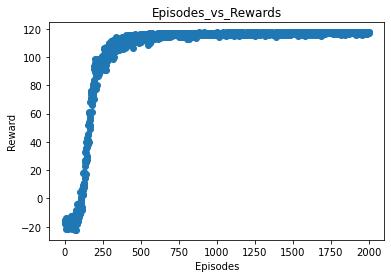

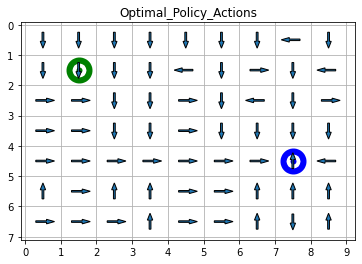

Average number of times goal was reached:  1826.83  representing 91.3415 %
Average episode number in which the agent was able to learn:  165.5


In [31]:
num_episodes = 2000
max_steps_per_episode = 100

learning_rate = 0.2
discount_rate = 0.95
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.005

filepath_e_vs_r = "episodes_vs_reward/v1.jpg"
filepath_optimal_policy = "optimal_policies/v1.jpg"
filepath_rewards = "rewards/rewards_v1.npy"

rewards_avg, q_table,num_times_goal_reached = rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)
plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath_e_vs_r)
plot_optimal_policy(q_table, filepath_optimal_policy)
save_rewards(filepath_rewards, rewards_avg)
print("Average number of times goal was reached: ", np.mean(num_times_goal_reached) ,f" representing {(np.mean(num_times_goal_reached)/num_episodes) *100} %")
print("Average episode number in which the agent was able to learn: ", get_max_reward_avg_episode(rewards_avg))

#### Version 2
    Our second way of rewarding the agent will be:
        1. -10 points if the agent gets out of the gameboard
        2. 260 points if the agent reaches the goal state
        3. 2 points for every step the agent makes
    Here we will try to see what happens if a positive reward is given for each step the agent makes. Will it be able to find the optimal path?

In [14]:
def get_reward(state):
    if state.x not in range(9) or state.y not in range(7):
        return -10
    if is_goal_state(state):
        return 260
    return 2

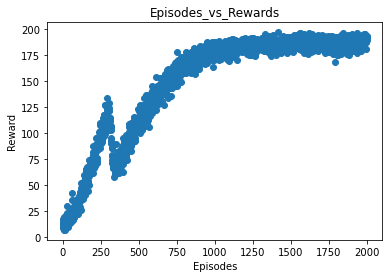

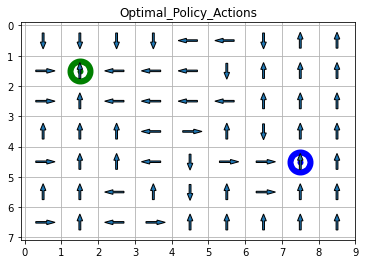

Average number of times goal was reached:  1.74  representing 0.087 %
Average episode number in which the agent was able to learn:  103.06


In [15]:
num_episodes = 2000
max_steps_per_episode = 100

learning_rate = 0.2
discount_rate = 0.95
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.005

filepath_e_vs_r = "episodes_vs_reward/v2.jpg"
filepath_optimal_policy = "optimal_policies/v2.jpg"
filepath_rewards = "rewards/rewards_v2.npy"

rewards_avg, q_table,num_times_goal_reached = rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)
plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath_e_vs_r)
plot_optimal_policy(q_table, filepath_optimal_policy)
save_rewards(filepath_rewards, rewards_avg)
print("Average number of times goal was reached: ", np.mean(num_times_goal_reached) ,f" representing {(np.mean(num_times_goal_reached)/num_episodes) *100} %")
print("Average episode number in which the agent was able to learn: ", get_max_reward_avg_episode(rewards_avg))

    We can observe that the agent is not able to find the goal. It does not learn correctly because we are rewarding the agent for each step it performs. As the maximum number of steps in a game was defined as 100, and every step gives the agent a reward of 2, the agent just tries to move inside the gameboard 100 times, reaching a reward of 200, but not reaching the goal state.
    As for the optimal policy, what we said above is confirmed, as the first step the agent takes is upward, and the second is downward, so the agent is stuck between these two boxes and does not move further.
    We learned how important it is to reward the agent in a good way.

#### Version 3
    Our third way of rewarding the agent will be:
        1. 0 points if the agent gets out of the gameboard
        2. 1 point if the agent reaches the goal state
        3. 0 points for every step the agent makes
    This way of rewarding is based on the lab practice for the Frozen Lake exercise, in which we identified that the agent got 0 reward when falling to a hole or getting out of the gameboard, and 1 of reward when reagching the goal state.

In [9]:
def is_out_of_range(state):
    return state.x not in range(9) or state.y not in range(7)
    
def get_reward(state):
    if is_out_of_range(state):
        return 0, True
    if is_goal_state(state):
        return 1, False
    return 0, False

def move(state, action):
    wind_val = {3:0.1, 4:0.2, 5:0.15}
    new_state = action(state)
    wind_treshold = np.random.random()
    wind_prob = wind_val.get(new_state.x)
    if wind_prob:
        if wind_treshold < wind_prob:
            new_state.y -= 1
    reward, out_of_range = get_reward(new_state)
    #out_of_range = is_out_of_range(new_state)
    done = is_goal_state(new_state) or out_of_range
    if out_of_range:
        new_state = None
    return new_state, reward, done

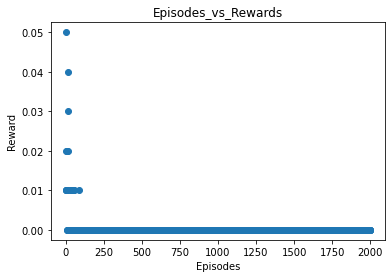

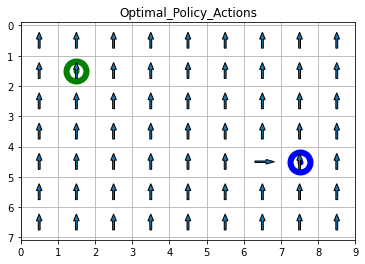

Average number of times goal was reached:  0.31  representing 0.0155 %
Average episode number in which the agent was able to learn:  4.36


In [10]:
num_episodes = 2000
max_steps_per_episode = 100

learning_rate = 0.2
discount_rate = 0.95
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.005

filepath_e_vs_r = "episodes_vs_reward/v3.jpg"
filepath_optimal_policy = "optimal_policies/v3.jpg"
filepath_rewards = "rewards/rewards_v3.npy"

rewards_avg, q_table,num_times_goal_reached = rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)
plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath_e_vs_r)
plot_optimal_policy(q_table, filepath_optimal_policy)
save_rewards(filepath_rewards, rewards_avg)
print("Average number of times goal was reached: ", np.mean(num_times_goal_reached) ,f" representing {(np.mean(num_times_goal_reached)/num_episodes) *100} %")
print("Average episode number in which the agent was able to learn: ", get_max_reward_avg_episode(rewards_avg))

    Here, we can observe that the agent is not able to learn. We think this way of rewarding, in which a reward of 0 is given when the agent does something wrong and for each step, and giving a reward of 1 when it reaches the goal, worked for the frozen lake case because the gameboard was smaller, so the agent was able to explore more and reach the goal. In this case, as the gameboard is bigger, the agent is not able to find the goal, therefore it stays with a reward of 0.
    In the next version we will just change the reward of getting out of the gameboard to -1:

#### Version 4
    Our fourth way of rewarding the agent will be:
        1. -1 points if the agent gets out of the gameboard
        2. 1 point if the agent reaches the goal state
        3. 0 points for every step the agent makes

In [11]:
def is_out_of_range(state):
    return state.x not in range(9) or state.y not in range(7)
    
def get_reward(state):
    if is_out_of_range(state):
        return -1, True
    if is_goal_state(state):
        return 1, False
    return 0, False

In [12]:
def move(state, action):
    wind_val = {3:0.1, 4:0.2, 5:0.15}
    new_state = action(state)
    wind_treshold = np.random.random()
    wind_prob = wind_val.get(new_state.x)
    if wind_prob:
        if wind_treshold < wind_prob:
            new_state.y -= 1
    reward, out_of_range = get_reward(new_state)
    #out_of_range = is_out_of_range(new_state)
    done = is_goal_state(new_state) or out_of_range
    if out_of_range:
        new_state = None
    return new_state, reward, done

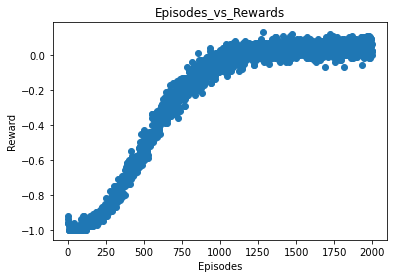

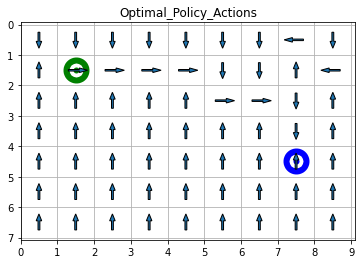

Average number of times goal was reached:  265.53  representing 13.276499999999999 %
Average episode number in which the agent was able to learn:  150.71


In [13]:
num_episodes = 2000
max_steps_per_episode = 100

learning_rate = 0.2
discount_rate = 0.95
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.005

filepath_e_vs_r = "episodes_vs_reward/v4.jpg"
filepath_optimal_policy = "optimal_policies/v4.jpg"
filepath_rewards = "rewards/rewards_v4.npy"

rewards_avg, q_table,num_times_goal_reached = rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)
plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath_e_vs_r)
plot_optimal_policy(q_table, filepath_optimal_policy)
save_rewards(filepath_rewards, rewards_avg)
print("Average number of times goal was reached: ", np.mean(num_times_goal_reached) ,f" representing {(np.mean(num_times_goal_reached)/num_episodes) *100} %")
print("Average episode number in which the agent was able to learn: ", get_max_reward_avg_episode(rewards_avg))

    Now the agent was able to learn, but it takes long. Giving a reward of -1 when the agent gets out of the gameboard was important, because due to this, the agent tried to stay in the gameboard and was able to find the corrrect path towards the goal. Also, as there are winds, we can see that the first row columns 3, 4, and 5 have the best action selected as DOWN, so the agent won't get out of the gameboard in case of wind. 

### Episodes vs Rewards

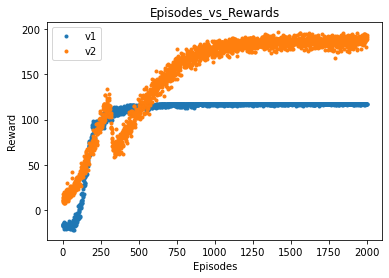

In [21]:
r_v1 = load_rewards("rewards/rewards_v1.npy")
r_v2 = load_rewards("rewards/rewards_v2.npy")

n = 2000
x = [i for i in range(0,n)]
y_v1 = np.mean(r_v1, axis=0)[:n]
y_v2 = np.mean(r_v2, axis=0)[:n]

plot.xlabel('Episodes')
plot.ylabel('Reward')
plot.plot(x, y_v1,'.')
plot.plot(x, y_v2,'.')

plot.title("Episodes_vs_Rewards")
plt.legend(['v1','v2'])
plt.savefig("episodes_vs_reward/comparation_v1_v2.jpg")
plt.show()

    Here, the amount of reward given also affects. Even though version 2 seems to have make the agent learn to reach the goal, it is just the agent getting reward for every step it makes in the gameboard without getting out of it, therefore version 1 is the only good way of rewarding that guarantees that the agent learned to reach the goal.

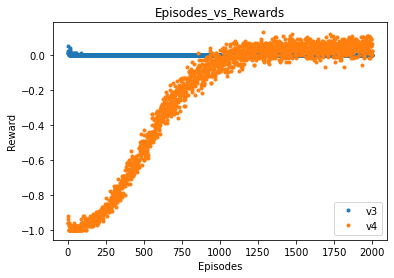

In [23]:
r_v3 = load_rewards("rewards/rewards_v3.npy")
r_v4  = load_rewards("rewards/rewards_v4.npy")

n = 2000
x = [i for i in range(0,n)]
y_v3 = np.mean(r_v3, axis=0)[:n]
y_v4 = np.mean(r_v4, axis=0)[:n]

plot.xlabel('Episodes')
plot.ylabel('Reward')
plot.plot(x, y_v3,'.')
plot.plot(x, y_v4,'.')

plot.title("Episodes_vs_Rewards")
plt.legend(['v3','v4'])
plt.savefig("episodes_vs_reward/comparation_v3_v4.jpg")
plt.show()

    Comparing version 3 and 4, we see that version 4 is the one that guaranteed the agent reached the goal.
    As for the number of episodes in which it learned, comparing both good versions, 1 and 4, we see that version 1 makes the agent learn faster, therefore this will be the way of rewarding used for all our experiments (seen in experiments_Parameters directory).

### Optimal Policy comparation

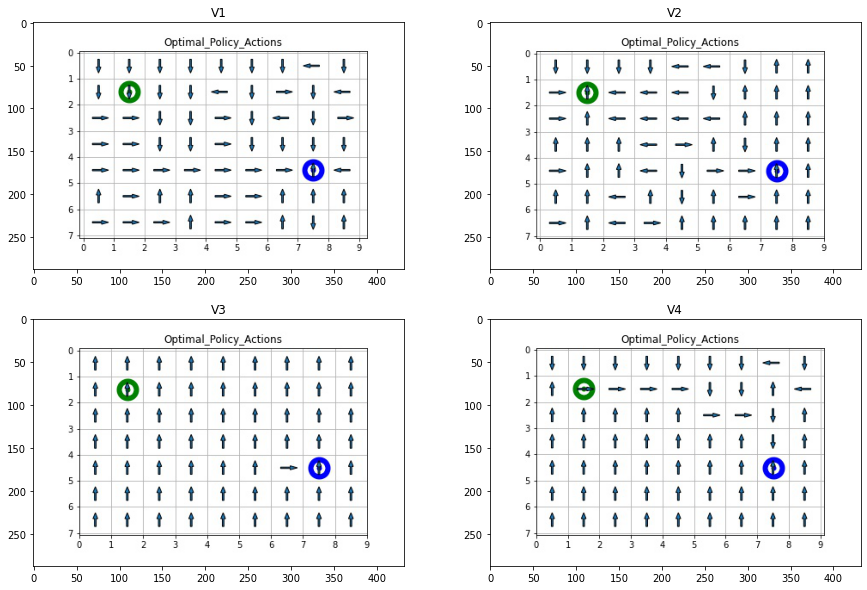

In [20]:
img1 = plt.imread('optimal_policies/v1.jpg')
img2 = plt.imread('optimal_policies/v2.jpg')
img3 = plt.imread('optimal_policies/v3.jpg')
img4 = plt.imread('optimal_policies/v4.jpg')

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(img1)
plt.title('V1')
#plt.show()

plt.subplot(2,2,2)
plt.imshow(img2)
plt.title('V2')
# plt.show()

plt.subplot(2,2,3)
plt.imshow(img3)
plt.title('V3')
# plt.show()

plt.subplot(2,2,4)
plt.imshow(img4)
plt.title('V4')

plt.show()

    As expected, policies of v2 and 3 are really bad. Policy of v2 gets stuck between 2 states, and policy v3 moves towards getting out of the gameboard. 
    Versions 1 and 4 are the best optimal policies found, since they guarantee the agent reaches the goal and it does not get out of the gameboard even if there is wind, directing the agent towards the opposite direction of the wind.